Parse all text from the downloaded HTML files.
2.      Explore the parsed output to learn how job skills are described in online postings. We’ll pay particular attention to whether certain HTML tags are more associated with skill descriptions.
3.      Attempt to filter any irrelevant job postings from the dataset.
4.      Cluster job skills based on text similarity.
5.      Visualize the clusters using word clouds.
6.      Adjust clustering parameters, if necessary, to improve the visualized output.
7.      Compare the clustered skills to our resume(*) to uncover missing skills.

In [268]:
#import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup

# Import and parse the .html files
Keep the body both with and without the html tags

In [269]:
data = []
folder = r"C:\Users\balin\Desktop\magnimind-assignments\NLP job_posting project\data\job_postings"

for filename in os.listdir(folder):
    if filename.endswith('.html'):
        full_path = os.path.join(folder, filename)
        with open(full_path, 'r', encoding='utf-8') as f:
            soup = BeautifulSoup(f, 'lxml')
            title = soup.title.text if soup.title else 'No Title'
           
            body_text = soup.body.get_text(separator='\n', strip=True) if soup.body else ''
            body_html = soup.body.prettify() if soup.body else ''
            
            data.append({'filename': filename, 'title': title, 'body_text': body_text, 'body_html': body_html})

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(data)


# Some basic dataset exploration

In [270]:
# Check for any nulls in the title
df[df['title'] == 'No Title']

,filename,title,body_text,body_html


In [271]:
print(df.columns)

Index(['filename', 'title', 'body_text', 'body_html'], dtype='object')


In [272]:
df.shape

(1458, 4)

In [273]:
df.head(10)

,filename,title,body_text,body_html
0,001b92395ed0fb62.html,"Data Scientist - Beavercreek, OH","Data Scientist - Beavercreek, OH\nData Scienti...","<body>\n <h2>\n Data Scientist - Beavercreek,..."
1,00321a48d04fe754.html,"Data Scientist - Seattle, WA 98101","Data Scientist - Seattle, WA 98101\nAre you in...","<body>\n <h2>\n Data Scientist - Seattle, WA ..."
2,0079c11b2611349f.html,"Data Scientist - Newark, CA","Data Scientist - Newark, CA\nData Scientist\nN...","<body>\n <h2>\n Data Scientist - Newark, CA\n..."
3,007d9d7b5c09d820.html,Patient Care Assistant / PCA - Med/Surg (Fayet...,Patient Care Assistant / PCA - Med/Surg (Fayet...,<body>\n <h2>\n Patient Care Assistant / PCA ...
4,00bf37ae19c7dfd7.html,"Data Manager / Analyst - Oakland, CA","Data Manager / Analyst - Oakland, CA\nHOW YOU ...",<body>\n <h2>\n Data Manager / Analyst - Oakl...
5,0125eabc844281c9.html,"Scientific Programmer - Berkeley, CA","Scientific Programmer - Berkeley, CA\nCaribou ...",<body>\n <h2>\n Scientific Programmer - Berke...
6,014ae4dbded805d2.html,JD Digits - AI Lab Research Intern - Mountain ...,JD Digits - AI Lab Research Intern - Mountain ...,<body>\n <h2>\n JD Digits - AI Lab Research I...
7,014ea972a4aa9812.html,Operations and Technology Summer 2020 Internsh...,Operations and Technology Summer 2020 Internsh...,<body>\n <h2>\n Operations and Technology Sum...
8,0179ea131f141400.html,PwC Labs - Jr. Data Scientist - Machine Learni...,PwC Labs - Jr. Data Scientist - Machine Learni...,<body>\n <h2>\n PwC Labs - Jr. Data Scientist...
9,018866568cd5a0b0.html,"Data and Reporting Analyst - Olympia, WA 98501","Data and Reporting Analyst - Olympia, WA 98501...",<body>\n <h2>\n Data and Reporting Analyst - ...


In [274]:
df.describe()


,filename,title,body_text,body_html
count,1458,1458,1458,1458
unique,1458,1364,1457,1457
top,_p.html,"Data Scientist - New York, NY","Physics Data Scientist - Foothill Ranch, CA\nT...",<body>\n <h2>\n Physics Data Scientist - Foot...
freq,1,13,2,2


In [275]:
# get simple statistics about length of body_text
df['body_text_length'] = df['body_text'].apply(len)
df['body_text_length'].describe()


count     1458.000000
mean      4222.222222
std       2052.157912
min         30.000000
25%       2904.250000
50%       3878.000000
75%       5042.000000
max      19040.000000
Name: body_text_length, dtype: float64

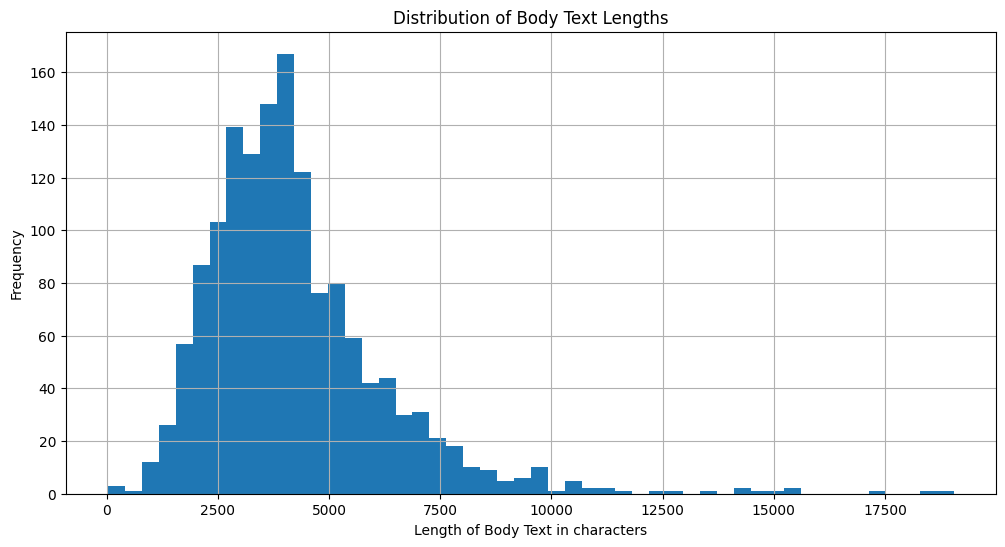

In [276]:
df['body_text_length'].hist(bins=50, figsize=(12, 6))
plt.title('Distribution of Body Text Lengths')
plt.xlabel('Length of Body Text in characters')
plt.ylabel('Frequency')
plt.show()

Some right-skew in the data, peak ~4000 characters inc. spaces, most fall between 2,000 and 7000 chars. some outliers w/very long descriptions

In [277]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   filename          1458 non-null   object
 1   title             1458 non-null   object
 2   body_text         1458 non-null   object
 3   body_html         1458 non-null   object
 4   body_text_length  1458 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 57.1+ KB


In [278]:
# Any duplicates based on the 'body_text' column
df[df['body_text'].duplicated(keep=False)].shape[0]

2

In [279]:
df = df.drop_duplicates(subset=['body_text'], keep='first')

In [280]:
df.shape

(1457, 5)

# Clean the data

In [281]:
df['body_text'][df['filename'] == '0179ea131f141400.html'].values[0][:1000]

'PwC Labs - Jr. Data Scientist - Machine Learning (NLP) - Tampa, FL 33607\nPwC Labs is focused on standardizing, automating, delivering tools and processes and exploring emerging technologies that drive efficiency and enable our people to reimagine the possible. Process improvement, transformation, effective use of innovative technology and data & analytics, and leveraging alternative delivery solutions are key areas of focus to drive additional value for our firm. The AI Lab focuses on implementing solutions that impact efficiency and effectiveness of our technology functions. Process improvement, transformation, effective use of technology and data & analytics, and leveraging alternative delivery are key areas to drive value and continue to be recognized as the leading professional services firm. AI Lab is focused on identifying and prioritizing emerging technologies to get the most out of our investments.\nTo really stand out and make us ?t for the future in a constantly changing wo

In [282]:
# Split the title roughly into job title and location on the last separator 
split = df['title'].str.rsplit(' - ', n=1, expand=True)
df['job_title'] = split[0]
df['location']  = split[1].fillna('Unknown') # for no location

In [283]:
df.drop(columns=['title','filename'], inplace=True)

In [284]:
df.sample(10)

,body_text,body_html,body_text_length,job_title,location
603,"Deal Desk Analyst - San Francisco, CA 94108\nL...",<body>\n <h2>\n Deal Desk Analyst - San Franc...,4039,Deal Desk Analyst,"San Francisco, CA 94108"
1345,Director of Data Science and Analytics - Seatt...,<body>\n <h2>\n Director of Data Science and ...,3838,Director of Data Science and Analytics,"Seattle, WA"
440,"Blockchain Analyst - Portland, OR\nDue to the ...",<body>\n <h2>\n Blockchain Analyst - Portland...,3683,Blockchain Analyst,"Portland, OR"
65,"Data Engineer - San Francisco, CA\ngoPuff is a...",<body>\n <h2>\n Data Engineer - San Francisco...,3706,Data Engineer,"San Francisco, CA"
633,"Data Science Instructor - San Francisco, CA\nS...",<body>\n <h2>\n Data Science Instructor - San...,4303,Data Science Instructor,"San Francisco, CA"
1155,"Senior Data Scientist - San Francisco, CA 9411...",<body>\n <h2>\n Senior Data Scientist - San F...,5596,Senior Data Scientist,"San Francisco, CA 94111"
1064,"Data Scientist, Growth Data Science - San Fran...","<body>\n <h2>\n Data Scientist, Growth Data S...",3629,"Data Scientist, Growth Data Science","San Francisco, CA 94103"
737,Intern - Telco and Edge Cloud - Wireless Netwo...,<body>\n <h2>\n Intern - Telco and Edge Cloud...,3678,Intern - Telco and Edge Cloud - Wireless Netwo...,"Palo Alto, CA 94304"
911,Biomedical Data Standards Specialist-Data Coll...,<body>\n <h2>\n Biomedical Data Standards Spe...,7943,Biomedical Data Standards Specialist-Data Coll...,"South San Francisco, CA 94083"
1347,Senior Natural Language Processing (NLP) Engin...,<body>\n <h2>\n Senior Natural Language Proce...,6011,Senior Natural Language Processing (NLP) Engineer,"Boston, MA"


In [285]:
def strip_header(row):
    """Remove job title and location header from job description body"""
    body_text, job_title, location = row['body_text'], row['job_title'], row['location']
    header = f"{job_title} - {location}"
    
    # If body starts with the exact header, remove it cleanly
    if body_text.startswith(header):
        return body_text[len(header):].lstrip('\n')
    
    # Otherwise keep the original text
    return body_text

df['body_text'] = df.apply(strip_header, axis=1)


In [286]:
df.sample(10)

,body_text,body_html,body_text_length,job_title,location
464,"June 2018, BetterDoctor and Quest Analytics me...","<body>\n <h2>\n Data Analyst - San Francisco,...",4631,Data Analyst,"San Francisco, CA"
1077,The Department of Energy Joint Genome Institut...,<body>\n <h2>\n Bioinformatics Associate Data...,6104,Bioinformatics Associate Data Scientist,"San Francisco Bay Area, CA 94598"
1244,Gain valuable on-the-job professional experien...,"<body>\n <h2>\n IT Intern - Fremont, CA 94539...",4699,IT Intern,"Fremont, CA 94539"
841,We are looking for a Data Analytics Manager to...,"<body>\n <h2>\n Data Analytics Manager, Royal...",2408,"Data Analytics Manager, Royalties and Accounting","New York, NY 10011"
442,The Senior Policy Researcher will work on larg...,<body>\n <h2>\n Senior Policy Researcher - Un...,3103,Senior Policy Researcher,United States
1032,Visitor Services Coordinator (6299U) - SIMONS ...,<body>\n <h2>\n Visitor Services Coordinator ...,8403,Visitor Services Coordinator (6299U) - SIMONS ...,"Berkeley, CA 94720"
1184,The Customer Success Manager is a crucial team...,<body>\n <h2>\n Customer Success Manager - Wa...,3515,Customer Success Manager,"Walnut Creek, CA"
964,Job Title:\nService Advisor\nDepartment:\nServ...,"<body>\n <h2>\n service advisor - Tracy, CA 9...",5416,service advisor,"Tracy, CA 95304"
1456,"Who we are!\nFor more than 70 years, scientist...",<body>\n <h2>\n Natural Language Processing U...,3571,Natural Language Processing Undergraduate Inte...,"Cambridge, MA"
1252,A two to three year position appointment which...,<body>\n <h2>\n Research Post Doctoral Fellow...,4601,Research Post Doctoral Fellow (Social Determin...,"Oakland, CA"


In [287]:
df['body_html'].iloc[3][:1000]

'<body>\n <h2>\n  Patient Care Assistant / PCA - Med/Surg (Fayette, AL) - Fayette, AL\n </h2>\n <h1 class="jobSectionHeader">\n  <b>\n   Performance Planning\n  </b>\n </h1>\n <p>\n  Provides personal care and support services under the supervision of a registered nurse that assists the patient in the achievement of physical and emotional comfort.\n </p>\n <h1 class="jobSectionHeader">\n  <b>\n   Key Responsibilities/Essential Functions\n  </b>\n </h1>\n <ul>\n  <li>\n   Provides all personal care services in accordance with the plan of treatment assigned by the registered nurse\n  </li>\n  <li>\n   Accurately documents care provided\n  </li>\n  <li>\n   Applies safety principles and proper body mechanics to the performance of specific techniques of personal and supportive care, such as ambulation of patients, transferring patients, assisting with normal range of motions and positioning\n  </li>\n  <li>\n   Participates in economical utilization of supplies and ensures that equipment a

## Job title analysis

Have a look at most common words in job titles

In [305]:
# Extract common terms from job titles
from collections import Counter
import re

# Tokenize job titles
def tokenize(text):
    return re.sub(r'[^\w\s]', ' ', text.lower()).split()

# Flatten all tokenized words from job titles
all_words = [word for title in df['job_title'] for word in tokenize(title)]

word_counts = Counter(all_words)

# Display top 20 word counts
print("Most common words in job titles:")
print(word_counts.most_common(10))

Most common words in job titles:
[('data', 749), ('scientist', 447), ('analyst', 189), ('engineer', 188), ('and', 174), ('science', 128), ('senior', 123), ('intern', 102), ('analytics', 83), ('manager', 82)]


In [288]:
df['job_title'].value_counts()

job_title
Data Scientist                      157
Senior Data Scientist                33
Data Analyst                         20
Data Engineer                        15
Machine Learning Engineer            12
                                   ... 
Senior Statistician                   1
Cyber Intelligence Analyst            1
Data & Tableau Reporting Analyst      1
Python Systems Engineer               1
Data Scientist - Oil and Gas          1
Name: count, Length: 1119, dtype: int64

Lots of different job titles with many similar roles having slightly different names. Will start by grouping these together ins ome way 

In [301]:
# Function to classifty job titles into categories
def classify_job_title(title):
    title = title.lower()
    categories = []
    if any(keyword in title for keyword in ['analyst', 'analytics']):
        categories.append('Data Analysis')
    if any(keyword in title for keyword  in ['scientist', 'science']):
        categories.append('Data Science')
    if any (keyword in title for keyword in ['engineer','engineering']):
        categories.append('Data Engineering')
    if any(keyword in title for keyword in ['machine learning', 'ml']):
        categories.append('Machine Learning')
    if any(keyword in title for keyword in ['developer', 'programer', 'programming', 'dev', 'software']):
        categories.append('Software Development')
    if any(keyword in title for keyword in ['researcher','research']):
        categories.append('Research')
    if any(keyword in title for keyword in ['manager', 'management']):
        categories.append('Management')
    if any(keyword in title for keyword in ['consultant', 'consulting']):
        categories.append('Consulting')
    if any(keyword in title for keyword in ['nurse', 'nursing']):
        categories.append('Nursing')
    
    if not categories:
       categories.append('Other')
    
    return categories

# Apply the function to the job_title column
df['job_categories'] = df['job_title'].apply(classify_job_title)
# Get all unique categories
all_categories = set()
for categories in df['job_categories']:
    all_categories.update(categories)

# Create binary columns for each category
for category in all_categories:
    df[f'is_{category.replace(" ", "_")}'] = df['job_categories'].apply(lambda x: category in x)


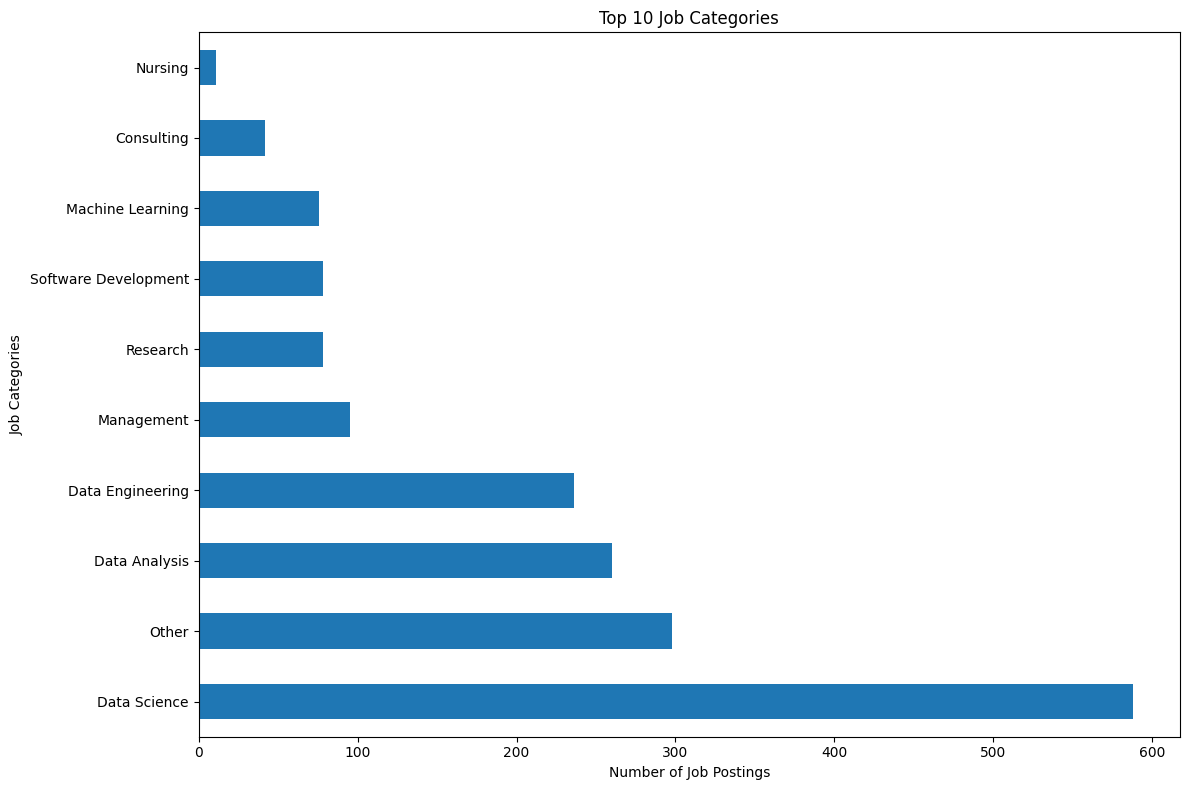

In [313]:
category_counts = df.explode('job_categories')['job_categories'].value_counts().head(10)

# Plot the top 10
category_counts.plot(kind='barh', figsize=(12, 8))
plt.title('Top 10 Job Categories')
plt.xlabel('Number of Job Postings')
plt.ylabel('Job Categories')
plt.tight_layout()
plt.show()

Have a look at 'other' category to see whether other groups jump out

In [292]:
others_jobs = df[df['is_Other'] == True]
others_jobs['job_title'].value_counts().sample(10)

job_title
Database Specialist/Compliance Monitor                                        1
Business Planning and Operations Associate - SBG                              1
Director, Predictive Modeling                                                 1
Sr. Test Technician                                                           1
Program and Data Assistant, Biology Scholars Program (4722C) - 1597 - 1597    1
Salesforce Administrator                                                      2
Financial Representative                                                      1
Lead of Genomics AI - Bay Area, CA                                            1
Linguist Intern, Summer 2020                                                  1
Leadership and Advocacy Coordinator                                           1
Name: count, dtype: int64

Have a look at the distribution of seniorty of roles

In [298]:
def extract_seniority(title):
    title = title.lower()
    
    if any(level in title for level in ['senior', 'sr', 'sr.', 'principal']):
        return 'Senior'
    elif any(level in title for level in ['junior', 'jr', 'jr.', 'associate','intern', 'entry-level','assistant']):
        return 'Junior'
    elif any(level in title for level in ['lead', 'head', 'chief', 'director', 'manager', 'president', 'vp']):
        return 'Leadership'
    else:
        return 'Mid-level'

df['seniority'] = df['job_title'].apply(extract_seniority)
seniority_counts = df['seniority'].value_counts()
print(seniority_counts)

seniority
Mid-level     898
Junior        236
Senior        183
Leadership    140
Name: count, dtype: int64


In [299]:
df[df['seniority'] == 'Mid-level']['job_title'].value_counts().sample(10)

job_title
RN                                                      1
Data Scientist - Natural Language Processing            2
eCommerce Data Science Analyst                          1
Wellness Promoter: Part-time                            1
Research Data Analyst                                   1
Data Analytic Engineer                                  1
Machine Learning Engineer (NLP)                         1
Data Analyst, Growth                                    1
Biomedical Data Standards Specialist-Data Collection    1
Quantitative Researcher                                 1
Name: count, dtype: int64

# Look at html tags and associations with skills

In [315]:
sample_df.head()

,body_text,body_html,body_text_length,job_title,location,job_categories,is_Data_Science,is_Consulting,is_Data_Engineering,is_Data_Analysis,is_Management,is_Research,is_Nursing,is_Software_Development,is_Other,is_Machine_Learning,seniority,html_analysis
1121,Job Description\nPublicis COSMOS is a new clas...,<body>\n <h2>\n Senior Data Scientist - San F...,6068,Senior Data Scientist,"San Francisco, CA 94104",[Data Science],True,False,False,False,False,False,False,False,False,False,Senior,"{'tag_counts': {'body': 1, 'h2': 1, 'br': 8, '..."
777,Science 37 is accelerating the research and de...,<body>\n <h2>\n Data Scientist - San Francisc...,4326,Data Scientist,"San Francisco, CA",[Data Science],True,False,False,False,False,False,False,False,False,False,Mid-level,"{'tag_counts': {'body': 1, 'h2': 1, 'li': 38},..."
1371,"Under general supervision, this position exist...",<body>\n <h2>\n Data Consultant - Genomic Ana...,5471,"Data Consultant - Genomic Analysis, R, Statist...","Oakland, CA",[Consulting],False,True,False,False,False,False,False,False,False,False,Mid-level,"{'tag_counts': {'body': 1, 'h2': 1, 'div': 4, ..."
235,"Founded in 2015, Instabase's mission is to adv...",<body>\n <h2>\n Support Engineer - San Franci...,3508,Support Engineer,"San Francisco, CA 94104",[Data Engineering],False,False,True,False,False,False,False,False,False,False,Mid-level,"{'tag_counts': {'body': 1, 'h2': 1, 'li': 8}, ..."
793,Job Description:\nThe Data Scientist is respon...,"<body>\n <h2>\n Data Scientist I - Charlotte,...",2816,Data Scientist I,"Charlotte, NC 28255",[Data Science],True,False,False,False,False,False,False,False,False,False,Mid-level,"{'tag_counts': {'body': 1, 'h2': 1, 'p': 9, 'b..."


K-means: fast, easy to apply, works well when clusters are compact, spherical and similar in size
Expectation-Maximisation (EM): often used with Gaussian Mixture models, handles clusters with different shapes, sizes, and orientations
- consider: scaling data, using PCA before clustering, and selecting number of clusters using BIC, AIC, silhouette score